# Scaling mega-pixel images classification via attention sampling
## Lymphoma subtype case study

In order to make this project work, prepare the dataset as follows:
```
. # current directory
|- this ipynb file
|- dataset
|  |- CLL
|  |  |- images for CLL class
|  |- FL
|  |  |- images for FL class
|  |- MCL
|     |- images for MCL class
|- model
   |- XXX_patches-XXX_pixels-XXX_attention_scaling_factor
      |- training
      |  |- XXX
      |     |- attention.data...
      |     |- attention.index
      |     |- checkpoint
      |     |- feature.data...
      |     |- feature.index
      |- accuracy.txt
      |- loss.txt
      |- validation_accuracy.txt
      |- validation_loss.txt
```

In [2]:
import tensorflow as tf
import numpy as np
import os
from PIL import Image
import json
import matplotlib.pyplot as plt

In [10]:
# for the meaning, check project.ipynb
LOAD_FROM_MEM_DATASET = False
LOAD_FROM_MEM_MODELS = False
NUM_PATCHES = 5
PATCH_SIZE = 20
ATTENTION_SCALING_FACTOR = 5
ENTROPY_COEF = 0.05
IMAGE_SIZE = (1000, 1300, 3)
BOUNDED_REWARD = True
REPEAT_BATCH = 4
NUM_CLASSES = 3
EPOCHS = 30
BATCH_SIZE = 8
TEMPERATURE = 3.
# number of images to consider
ONLY_FIRST_N = 5

## Dataset loading

In [4]:
if LOAD_FROM_MEM_DATASET:
    FL_paths = list(os.listdir("./dataset/FL"))
    CLL_paths = list(os.listdir("./dataset/CLL"))
    MCL_paths = list(os.listdir("./dataset/MCL"))
    FL_images = np.array([np.array(Image.open(f"./dataset/FL/{el}")) for el in FL_paths])
    CLL_images = np.array([np.array(Image.open(f"./dataset/CLL/{el}")) for el in CLL_paths])
    MCL_images = np.array([np.array(Image.open(f"./dataset/MCL/{el}")) for el in MCL_paths])
    labels = np.concatenate((
        np.full((FL_images.shape[0],), 0),
        np.full((CLL_images.shape[0],), 1),
        np.full((MCL_images.shape[0],), 2)
    ))
    data = np.concatenate((
        FL_images,
        CLL_images,
        MCL_images
    ))
    with open("./cache/labels", "wb+") as file:
        np.save(file, labels)
    with open("./cache/data", "wb+") as file:
        np.save(file, data)
else:
    with open("./cache/labels", "rb") as file:
        labels = np.load(file)
    with open("./cache/data", "rb") as file:
        data = np.load(file)

In [ ]:
perm = np.random.permutation(len(data))
data = data[perm]
labels = labels[perm]
data_train = data[:int(len(data) * 0.7)]
labels_train = labels[:int(len(labels) * 0.7)]
data_val = data[int(len(data) * 0.7):int(len(data) * 0.85)]
labels_val = labels[int(len(labels) * 0.7):int(len(labels) * 0.85)]
data_test = data[int(len(data) * 0.85):]
labels_test = labels[int(len(labels) * 0.85):]
val_dataset = (
    tf.data.Dataset.from_tensor_slices((data_val, labels_val))
       .shuffle(500)
       .batch(BATCH_SIZE)
       .map(lambda x, y: (tf.cast(x, tf.float32), y))
       .map(lambda x, y: (tf.clip_by_value(x, 0., 255.) / 255., y))
       .map(lambda x, y: (tf.image.random_crop(x, (tf.shape(x)[0], 1000, 1300, 3)), y))
)
test_dataset = (
    tf.data.Dataset.from_tensor_slices((data_test, labels_test))
        .shuffle(500)
        .batch(BATCH_SIZE)
        .map(lambda x, y: (tf.cast(x, tf.float32), y))
        .map(lambda x, y: (tf.clip_by_value(x, 0., 255.) / 255., y))
        .map(lambda x, y: (tf.image.random_crop(x, (tf.shape(x)[0], 1000, 1300, 3)), y))
)
random_zoom = tf.keras.layers.RandomZoom((0., 0.6))
train_dataset = (
    tf.data.Dataset.from_tensor_slices((data_train, labels_train))
         .shuffle(500)
         .batch(BATCH_SIZE)
         .map(lambda x, y: (tf.cast(x, tf.float32), y))
         .map(lambda x, y: (tf.image.random_flip_left_right(x), y))
         .map(lambda x, y: (tf.image.random_contrast(x, 0.99, 0.999), y))
         .map(lambda x, y: (tf.clip_by_value(x, 0., 255.) / 255., y))
         .map(lambda x, y: (tf.image.random_crop(x, (tf.shape(x)[0], 1000, 1300, 3)), y))
         .map(lambda x, y: (random_zoom(x), y))
)

## Models

In [6]:
FOLDER_NAME = f"./model/{NUM_PATCHES:03.0f}_patches-{PATCH_SIZE:03.0f}_pixels-{ATTENTION_SCALING_FACTOR:03.0f}_attention_scaling_factor"
os.makedirs(FOLDER_NAME, exist_ok=True)

In [7]:
def multi_dimension_softmax(tensor):
    e_t = tf.exp(tensor)
    total = tf.reduce_sum(e_t, axis=(1,2,3), keepdims=True)
    return e_t / total
attention_network = tf.keras.Sequential([
    tf.keras.layers.AveragePooling2D(ATTENTION_SCALING_FACTOR),
    tf.keras.layers.Conv2D(8, 3, activation=tf.nn.leaky_relu, padding="SAME"),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv2D(8, 3, activation=tf.nn.leaky_relu, padding="SAME"),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv2D(8, 3, activation=tf.nn.leaky_relu, padding="SAME"),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv2D(1, 3, padding="SAME"),
    tf.keras.layers.Lambda(multi_dimension_softmax)
])

In [8]:
epoch = int(input("epoch to load: "))

In [9]:
attention_network.load_weights(f"{FOLDER_NAME}/training/{epoch:03.0f}/attention")
with open(f"{FOLDER_NAME}/loss.txt", "rb+") as file:
    losses = json.load(file)
with open(f"{FOLDER_NAME}/accuracy.txt", "rb+") as file:
    accuracies = json.load(file)
with open(f"{FOLDER_NAME}/validation_loss.txt", "rb+") as file:
    validation_losses = json.load(file)
with open(f"{FOLDER_NAME}/validation_accuracy.txt", "rb+") as file:
    validation_accuracies = json.load(file)

In [23]:
x,y = next(iter(test_dataset))
images = x[0:ONLY_FIRST_N]
targets = y[0:ONLY_FIRST_N]
# calculate attention and sample
attention = attention_network(images)
flatten = tf.reshape(attention, (attention.shape[0], -1))
sampled = tf.random.categorical(tf.math.log(flatten), NUM_PATCHES, dtype=tf.int32)
sampled_indexes = tf.reshape(
    tf.concat((
        tf.repeat(tf.range(sampled.shape[0])[...,None], sampled.shape[1], axis=-1)[..., None],
        sampled[..., None]
    ), axis=-1),
    (-1, 2)
)
selected_patches_probs = tf.gather_nd(flatten, sampled_indexes)

sampled = sampled.numpy().reshape((-1,))
x = (sampled % attention.shape[2]).reshape((-1,NUM_PATCHES,1))
y = (sampled // attention.shape[2]).reshape((-1,NUM_PATCHES,1))
pairs = np.concatenate((y,x), axis=-1)
mask = np.argwhere(np.ones((PATCH_SIZE,PATCH_SIZE))==1).T[None,None,...] - PATCH_SIZE//2
indexes = ((pairs * ATTENTION_SCALING_FACTOR)[...,None]+mask)

In [24]:
patches = []
for image, patches_index in zip(images.numpy(), indexes):
    patches.append([
        np.pad(image,((0, PATCH_SIZE),(0, PATCH_SIZE),(0, 0)), mode="reflect")[index[0], index[1]].reshape((PATCH_SIZE,PATCH_SIZE,3))
        for index in patches_index])
patches = np.array(patches)

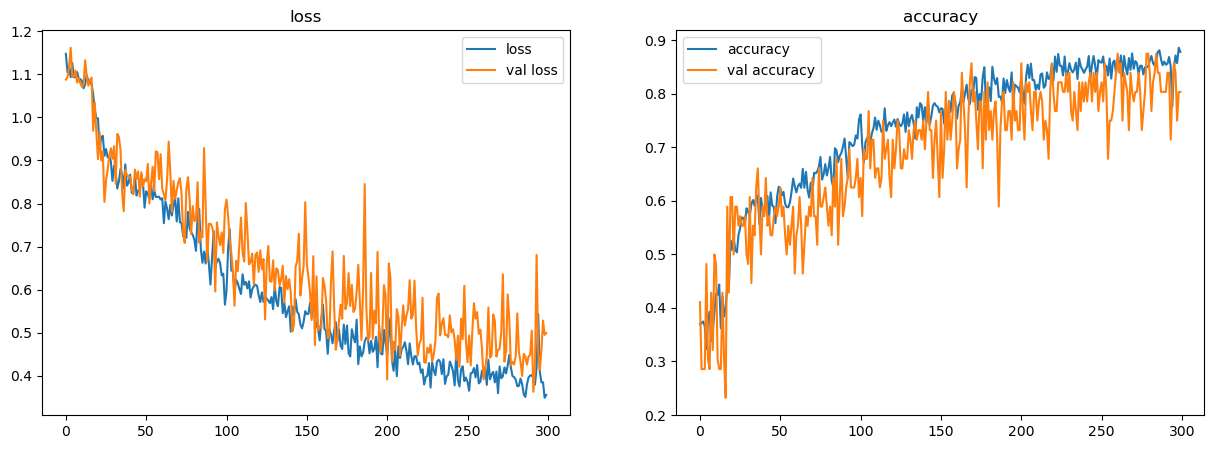

In [25]:
fig, axs = plt.subplots(1, 2, dpi=100, figsize=(15,5))
axs[0].plot(losses)
axs[0].plot(validation_losses)
axs[0].set_title("loss")
axs[0].legend(["loss", "val loss"])
axs[1].plot(accuracies)
axs[1].plot(validation_accuracies)
axs[1].set_title("accuracy")
axs[1].legend(["accuracy", "val accuracy"])

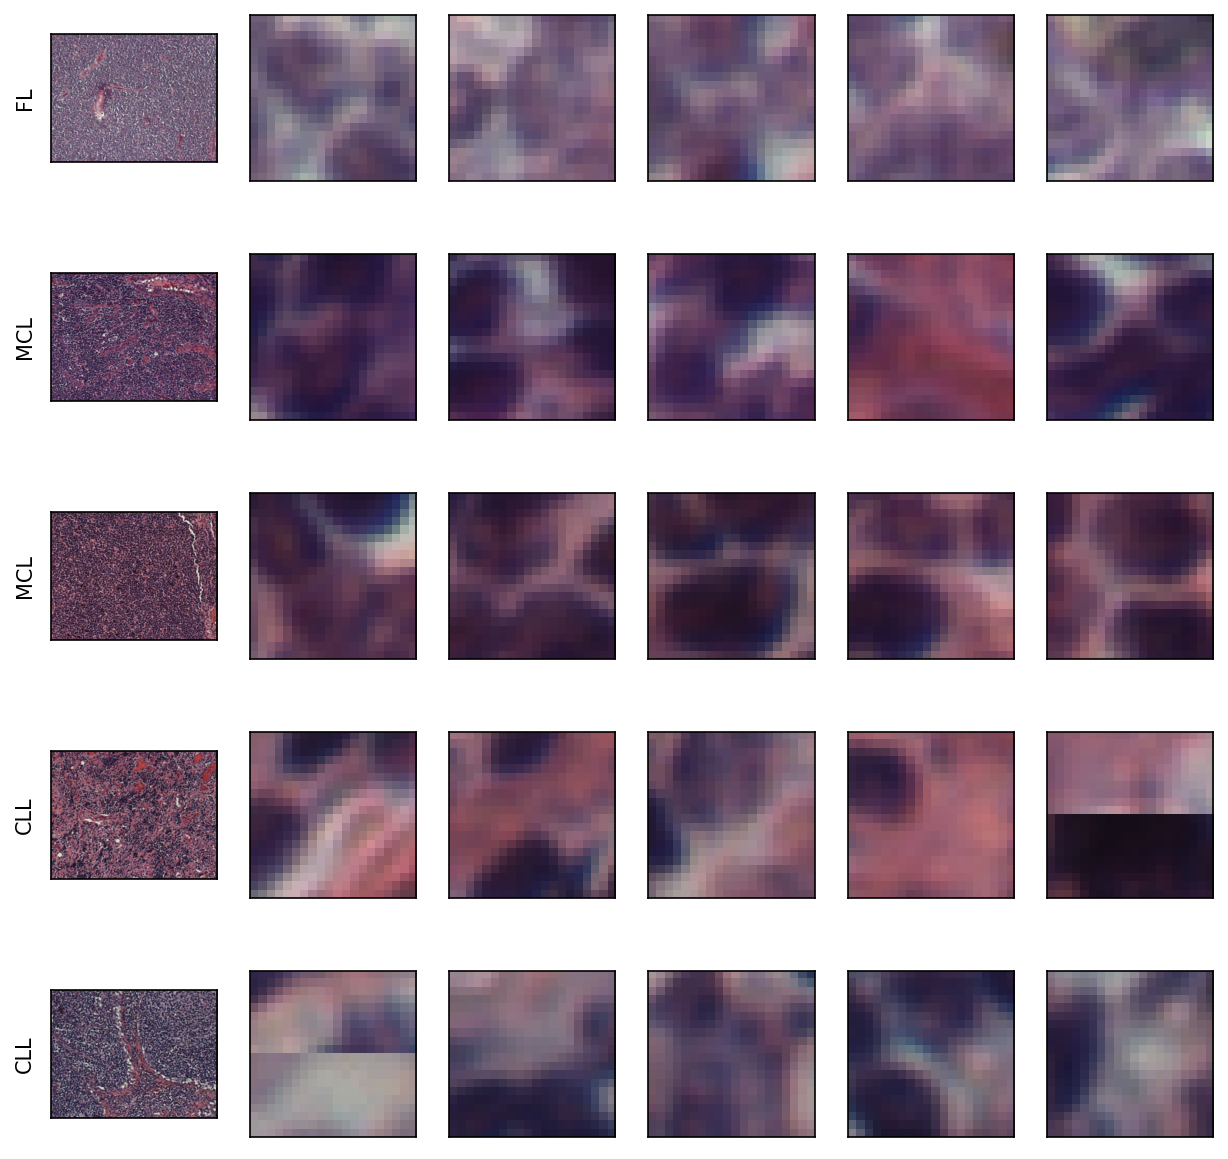

In [26]:
fig, axss = plt.subplots(images.shape[0], NUM_PATCHES+1, dpi=150, figsize=(10,10))
for i,t,ps,axs in zip(images.numpy(), targets.numpy(), patches, axss):
    axs[0].set_ylabel({
                          0: "CLL",
                          1: "FL",
                          2: "MCL",
                      }[t])
    axs[0].imshow(i)
    axs[0].set_xticks([])
    axs[0].set_yticks([])
    for ax,p in zip(axs[1:], ps):
        ax.imshow(p)
        ax.set_xticks([])
        ax.set_yticks([])

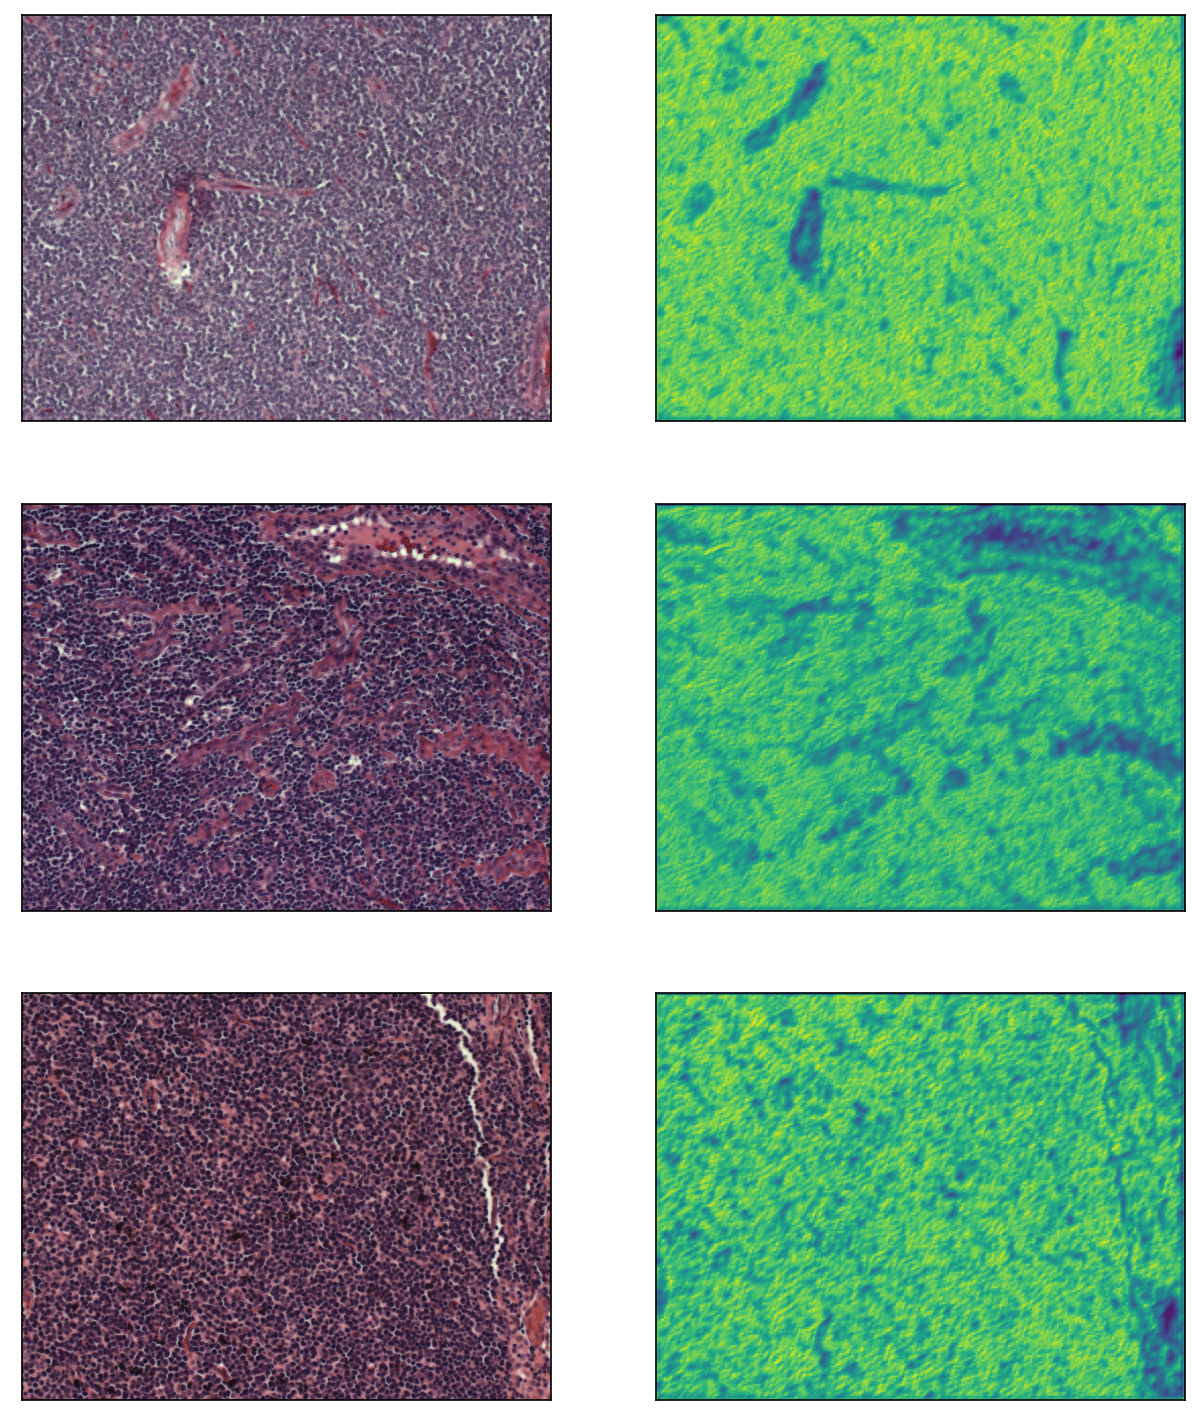

In [27]:
fig, axss = plt.subplots(3, 2, dpi=150, figsize=(10,12))

for i,a,axs in zip(images.numpy()[:3], attention.numpy(), axss):
    axs[0].imshow(i)
    axs[0].set_xticks([])
    axs[0].set_yticks([])
    axs[1].imshow(a)
    axs[1].set_xticks([])
    axs[1].set_yticks([])